### Libraries

In [1]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.ndimage.interpolation import zoom
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
#!pip install git+https://github.com/facebookresearch/fvcore.git

/tmp/ipykernel_68927/869572070.py:17: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [2]:
pwd

'/scratch/student/shokoofa'

In [3]:
original_address = '/scratch/student/shokoofa/'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [4]:
paths = glob.glob(os.path.join(original_address + '/dataset/**/*', '*')) #numebr of all samples per patients
len(paths)

5303

### Load the csv file containing the image file names and corresponding labels

In [5]:
info_train = pd.read_csv(os.path.join(original_address , 'train_labels.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'val_labels.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'test_labels.csv'))

In [6]:
info_train['path'][100], info_train['label'][100]

('Train/6fwt32TiT_KD-QU8t64_eg/82', 'Subcostal')

### Preprocessing

### Define Transformers

In [7]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = 0
        left = w // 10
        return img.crop((left, top, w, new_h))
    
class AddGaussianNoise:
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
# def preprocessing( image_array, k = 100):
#     slices, ch, height, width = image_array.shape

#     mask = torch.zeros((ch, height, width), dtype=torch.uint8)
#     steps = min(k, slices)
#     for i in range(steps - 1):
#         mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

#     output = image_array * mask
#     return output

all_data_transform = transforms.Compose([
    CustomCrop(),
    # transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # transforms.Lambda(lambda img: preprocessing(img)),
    # Lambda(lambda x: x/255)
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = transforms.Compose([
    # CustomCrop(),
    # transforms.Resize((256, 256)),
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    # transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.2),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.2),  # Brightness & contrast
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p=0.2),
    
])


### Map images to their labels

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, starts, ends, transform, training_transform = None):
        self.paths = paths
        self.labels = labels
        self.starts = starts
        self.ends = ends
        self.transform = transform
        self.training_transform = training_transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, label, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

        output = image_array * mask
        # visualization(mask[0], label)
        return output

    def address(self,index):
        return original_address + '/dataset/' + self.paths[index]
    
                
    def __getitem__(self, index):
        # Get the filename and label for the current index
        filepath = original_address + '/dataset/' + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])


        # sort the image in based on the order of the slices saved in the folder
        # imgs_paths = sorted(glob.glob(os.path.join(filepath, '*')), key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))
        addresses = []
        for i in range(self.starts[index], self.ends[index]+1):
            addresses.append(filepath + '/' + filepath.split('/')[-1] + '_' + str(i) + '.jpeg')

        imgs_paths = sorted(addresses, key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))

        images_list = []
        for img_path in imgs_paths:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)
        sequence_tensor = torch.stack(images_list)
        preprocessed_sequence = self.preprocessing(sequence_tensor, label)
        if self.training_transform is not None:
            preprocessed_sequence = torch.stack([self.training_transform(to_pil(image)) for image in preprocessed_sequence])


        # creating a 3D tensor image
        # sequence_tensor = torch.stack(images_list)
        # # chunks = self.sliding_window(sequence_tensor)
        
        # preprocessed_d = self.preprocessing(sequence_tensor, label)

        # Return the image and label as tensors
        return preprocessed_sequence, label

    # def number_of_classes(self):
    #   return self.data[:,1].max() + 1

In [9]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [10]:
train_data = CustomDataset(info_train['path'], info_train['label'],info_train['start'], info_train['end'], transform=all_data_transform, training_transform=train_transform)
val_data = CustomDataset(info_val['path'], info_val['label'],info_val['start'], info_val['end'], transform=all_data_transform)
test_data = CustomDataset(info_test['path'], info_test['label'],info_test['start'], info_train['end'], transform=all_data_transform)

/scratch/student/shokoofa//dataset/Train/6fwt32TiT_KD-QU8t64_eg/47


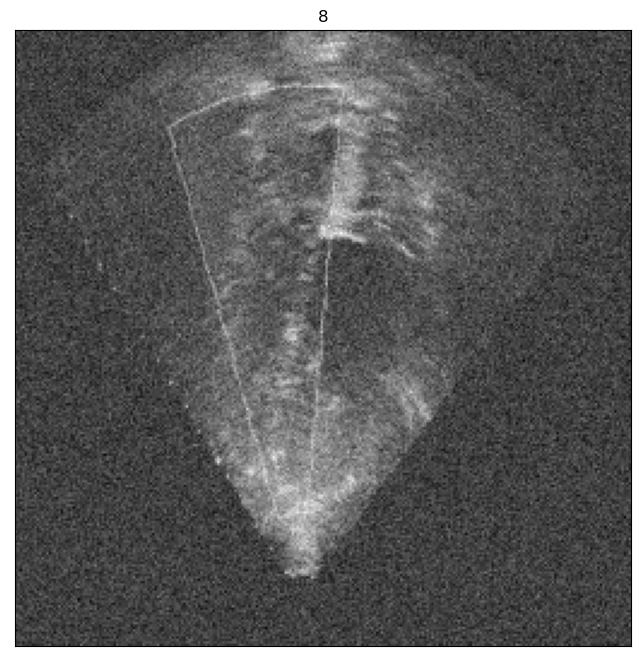

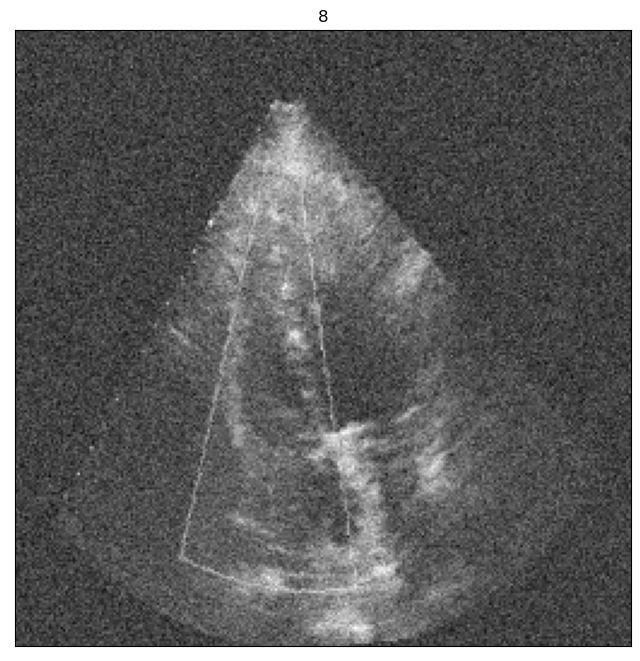

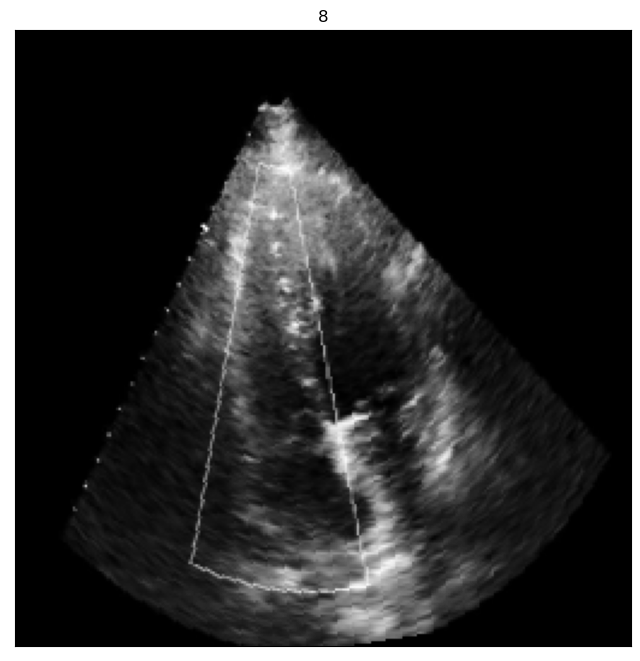

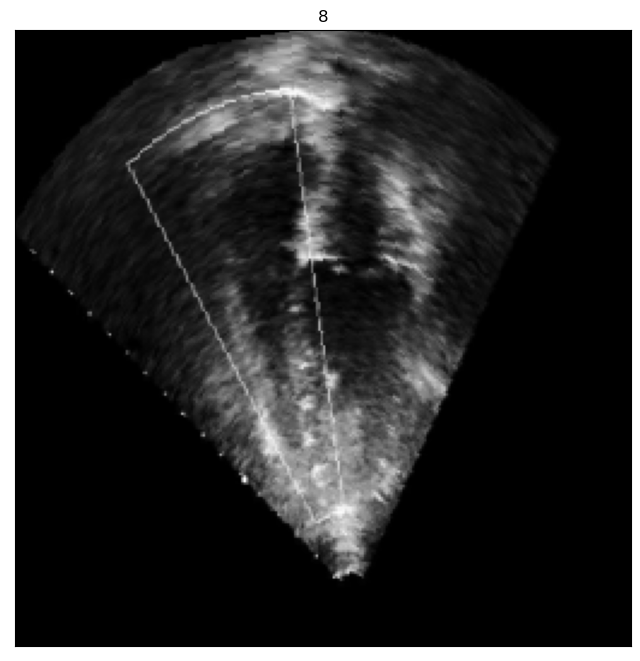

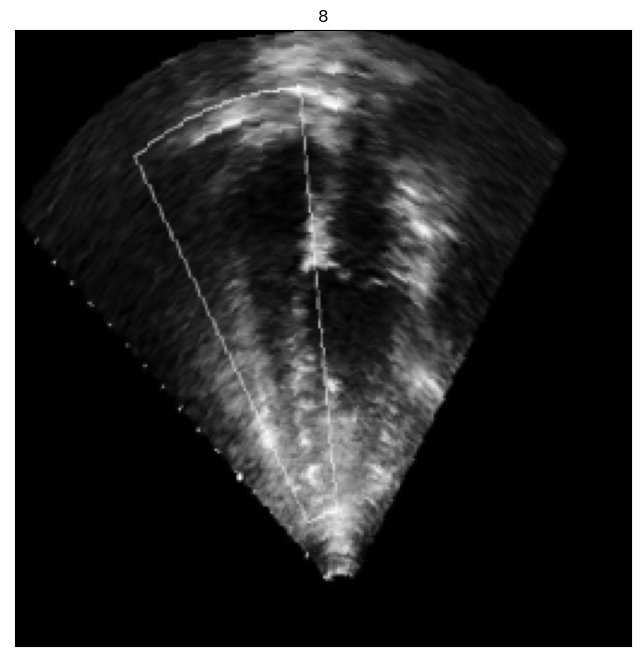

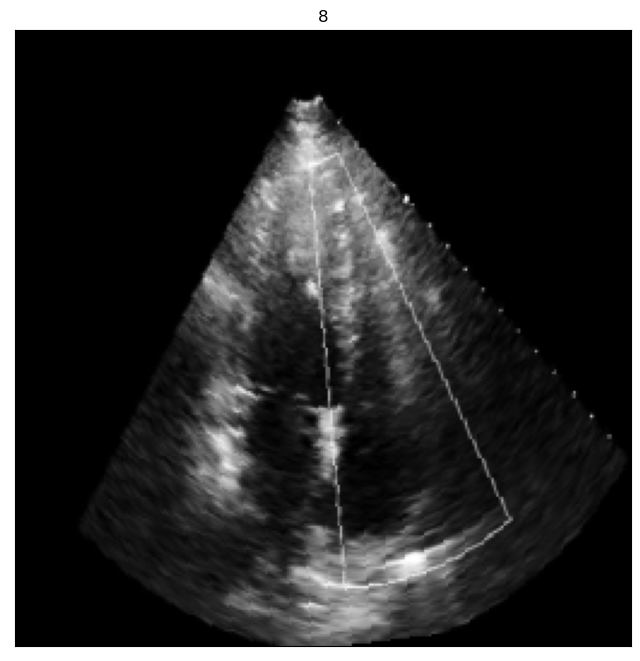

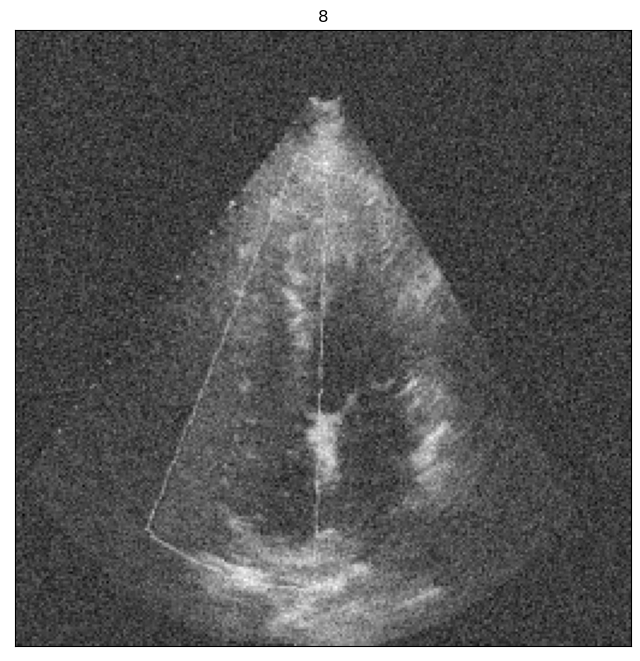

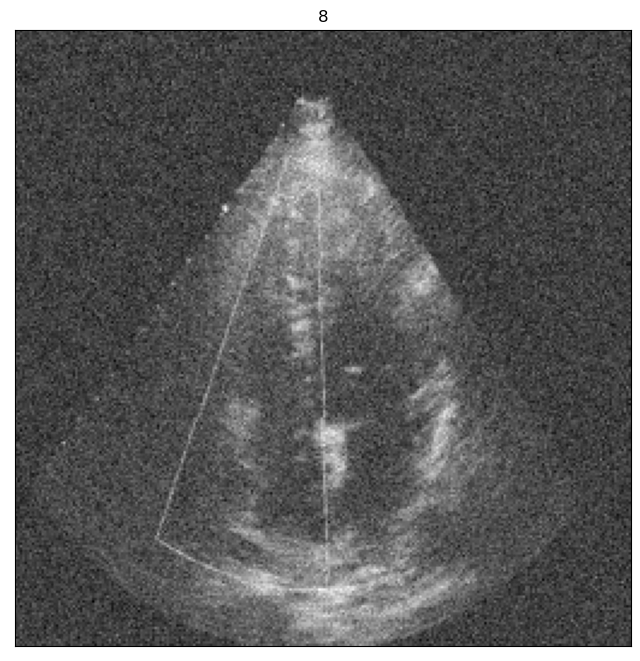

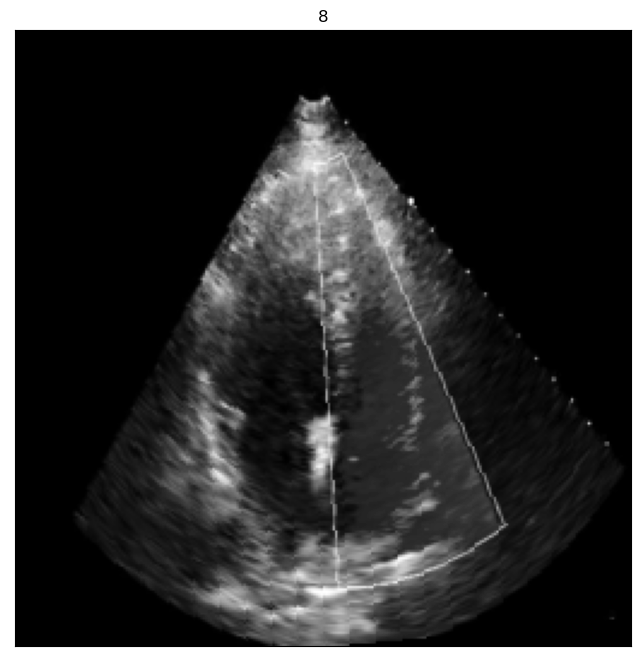

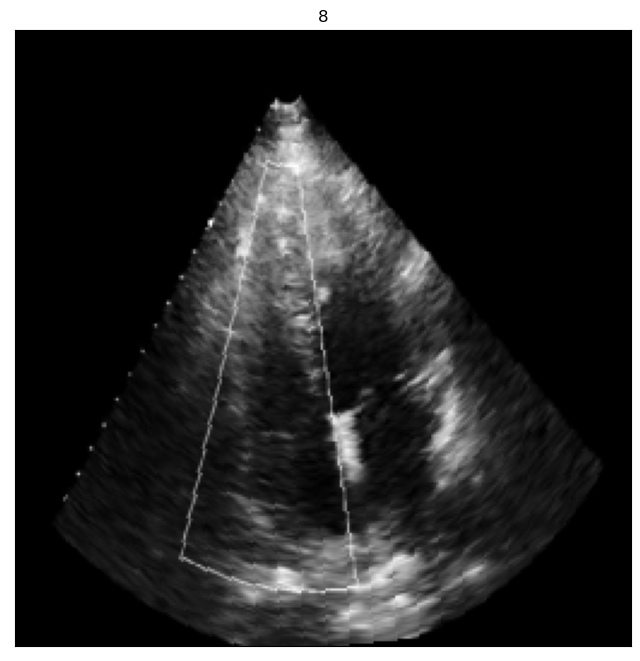

In [11]:
print(train_data.address(10))
for i in range(len(train_data[10][0][:])):
    visualization(train_data[10][0][i,-1], train_data[10][1])

### Create data loaders for the train and validation sets



In [30]:
train_loader = DataLoader(train_data, batch_size=64, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=64, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=64, drop_last=True, shuffle=False, pin_memory=True, num_workers= 8, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [13]:
for img, lbl in train_loader:
    print(img.shape)
    print(lbl)
    break

torch.Size([64, 10, 3, 256, 256])
tensor([[10],
        [ 9],
        [ 0],
        [10],
        [ 8],
        [ 7],
        [10],
        [ 6],
        [ 8],
        [ 5],
        [ 0],
        [ 2],
        [ 2],
        [ 1],
        [ 5],
        [ 1],
        [ 2],
        [ 5],
        [ 1],
        [ 5],
        [ 8],
        [ 8],
        [ 0],
        [ 2],
        [10],
        [ 1],
        [ 5],
        [ 8],
        [ 1],
        [10],
        [ 8],
        [ 5],
        [ 9],
        [ 0],
        [ 5],
        [ 0],
        [ 0],
        [ 8],
        [ 3],
        [10],
        [ 0],
        [ 7],
        [ 5],
        [ 0],
        [ 6],
        [ 6],
        [ 5],
        [10],
        [ 8],
        [ 3],
        [ 1],
        [ 0],
        [10],
        [ 1],
        [ 4],
        [ 8],
        [ 8],
        [ 1],
        [ 5],
        [ 0],
        [ 2],
        [ 7],
        [10],
        [ 0]])


### Define the neural network model architecture

In [31]:
# class CNNLSTM(nn.Module):
#     def __init__(self, in_channels, cnn_output_size, num_classes):
#         super(CNNLSTM, self).__init__()

#         self.hidden_size = 100
#         self.num_layers = 2
#         self.num_classes = num_classes
#         self.cnn_output_size = cnn_output_size

#         self.conv = torchvision.models.resnet18(pretrained = False)
#         # self.conv = torchvision.models.efficientnet_b0(pretrained=False)
#         # self.conv = torchvision.models.inception_v3(weights='DEFAULT')
#         # self.conv.trainable = False
#         # for param in self.conv.parameters():
#         #     param.requires_grad = False

#         # for param in model.parameters():
#         #     param.requires_grad = False

#         # # Unfreeze the parameters of the last stage (depends on the implementation)
#         # # For example, if we assume that the last stage is named `_blocks`,
#         # # and you want to unfreeze the last two blocks:
#         # for block in model.features[-2:]:
#         #     for param in block.parameters():
#         #         param.requires_grad = True

#         # # Replace the classifier (the final fully connected layer)
#         # num_features = model.classifier[1].in_features 
#         self.gru = nn.GRU(input_size= self.cnn_output_size, 
#                           hidden_size=self.hidden_size, 
#                           num_layers=self.num_layers, 
#                           batch_first=True)
#         # self.lstm = nn.LSTM(self.cnn_output_size, self.hidden_size, self.num_layers, batch_first=True)
#         # self.classifier_layer = nn.Sequential( 
#         #     nn.Linear(self.hidden_size, 256), 
#         #     nn.ReLU(),
#         #     nn.Dropout(0.2), 
#         #     nn.Linear(256, num_classes))
#         self.classifier_layer = nn.Sequential( nn.Linear(self.hidden_size, num_classes))

#     def forward(self, x):
#         batch_size , seq_len, C, H, W = x.size()
#         c_in = x.view( batch_size * seq_len, C, H, W)
#         # print(c_in.shape)
#         c_out = self.conv(c_in)
#         # if self.training: #JUST FOR INCEPTION
#         #     c_out = c_out[0]
        
#         # c_out = F.adaptive_avg_pool2d(c_out, (1,1))
        
#         # c_out = c_out.view(c_out.size(0), -1)
#         # print(c_out)
#         lstm_in = c_out.view(batch_size, seq_len, -1)
#         # print(lstm_in.shape)
#         # lstm_out, _ = self.lstm(lstm_in)
#         lstm_out, _ = self.gru(lstm_in)


#         lstm_out = lstm_out[:, -1, :]

#         output = self.classifier_layer(lstm_out)
#         return output


# cnn_output_size = 1000
# model = CNNLSTM(3,cnn_output_size, 11)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNNLSTM, self).__init__()
        # Define the CNN part
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_cnn = nn.Dropout(0.25) 
        # Define the RNN part
        self.lstm = nn.LSTM(input_size=32*64*64, hidden_size=256, num_layers=1, batch_first=True)
        # Define the final fully connected layer
        self.fc = nn.Linear(256, num_classes)
        self.dropout_fc = nn.Dropout(0.5)
        
        
    def forward(self, x):
        # Initialize hidden and cell state
        h0 = torch.zeros(1, x.size(0), 256).to(x.device) # (num_layers, batch, hidden_size)
        c0 = torch.zeros(1, x.size(0), 256).to(x.device)
        
        # Process each time step
        cnn_out = []
        for t in range(x.size(1)):
            # Extract the t-th time step for all examples in the batch
            xt = x[:, t, :, :, :]
            # Apply the CNN
            xt = F.relu(self.conv1(xt))
            xt = self.pool(xt)
            xt = self.dropout_cnn(xt)
            xt = F.relu(self.conv2(xt))
            xt = self.pool(xt)
            xt = self.dropout_cnn(xt)
            # xt = F.relu(self.conv3(xt))
            # xt = self.pool(xt)
            # Flatten the output
            xt = xt.view(x.size(0), -1)
            cnn_out.append(xt)
        
        # Stack the CNN outputs to form a new sequence
        cnn_out = torch.stack(cnn_out, dim=1)
        
        # Apply the LSTM
        lstm_out, (hn, cn) = self.lstm(cnn_out, (h0, c0))
        
        # Only use the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(last_time_step_out)
        
        return out

# Instantiate the model
num_classes = 11
model = SimpleCNNLSTM(num_classes)


In [33]:
input1 = torch.rand(8, 10, 3, 256, 256)
# input2 = torch.rand(8, 10, 3, 299, 299)
# model.eval()
print(model(input1).shape)
# print(model(input2))

torch.Size([8, 11])


### Define loss and optimizer

In [34]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0

True

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
# model.lstm.flatten_parameters() 
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")

  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.9)

print(device)

Let's use 2 GPUs!
cuda


In [36]:
# i= 0
# for img, lbl in val_loader:
#     if(i<5):
#         model.eval()
#         images = img.to(device)
#         labels = lbl.to(device)
#         labels = labels.squeeze(1)
#         print(labels)
#         output = model(images)
#         _, predictions = output.max(1)
#         print(output)
#         print(predictions)
#         loss = criterion(output, labels)
#         print(loss.item())
#         i += 1
    


### Train the model

In [39]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print('Valid \t',  predictions, labels, labels == predictions, total_correct, total, images.size(0), '\n')

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [40]:
# model = model.to(device)
epochs = 30
# BATCH_SIZE = 64
accs = []
losses = []
val_loss = 0.0
best_val_loss = float('inf')
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  # epochs_no_improve = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    # print(images)
    # print(outputs)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()
    # print('TRAIN:', predictions, labels,  running_corrects, '\n')
    # total_loss += loss.item() * images.size(0)
    
  # accuracy = total_correct / total
  if (epoch%10 == 0):
    torch.save(model.state_dict(), (f'/scratch/student/shokoofa/model{epoch}.pth'))

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, criterion, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 3:
    print('no further improvement')
    break


Train epoch 0: Loss(1.8971, Accuracy (0.35898) )
valid epoch 0: Loss(1.6316),  Accuracy (0.4645))
---
Train epoch 1: Loss(1.3615, Accuracy (0.57083) )
valid epoch 1: Loss(1.4121),  Accuracy (0.5120))
---
Train epoch 2: Loss(1.0759, Accuracy (0.67376) )
valid epoch 2: Loss(1.3005),  Accuracy (0.5823))
---
Train epoch 3: Loss(0.8647, Accuracy (0.74727) )
valid epoch 3: Loss(1.2455),  Accuracy (0.5901))
---
Train epoch 4: Loss(0.6904, Accuracy (0.81348) )
valid epoch 4: Loss(1.1853),  Accuracy (0.6238))
---
Train epoch 5: Loss(0.5438, Accuracy (0.86374) )
valid epoch 5: Loss(1.1587),  Accuracy (0.6316))
---
Train epoch 6: Loss(0.4267, Accuracy (0.90475) )
valid epoch 6: Loss(1.1184),  Accuracy (0.6340))
---
Train epoch 7: Loss(0.3237, Accuracy (0.93509) )
valid epoch 7: Loss(1.0709),  Accuracy (0.6544))
---
Train epoch 8: Loss(0.2489, Accuracy (0.95781) )
valid epoch 8: Loss(1.0645),  Accuracy (0.6442))
---
Train epoch 9: Loss(0.1886, Accuracy (0.97194) )
valid epoch 9: Loss(1.0558),  Acc

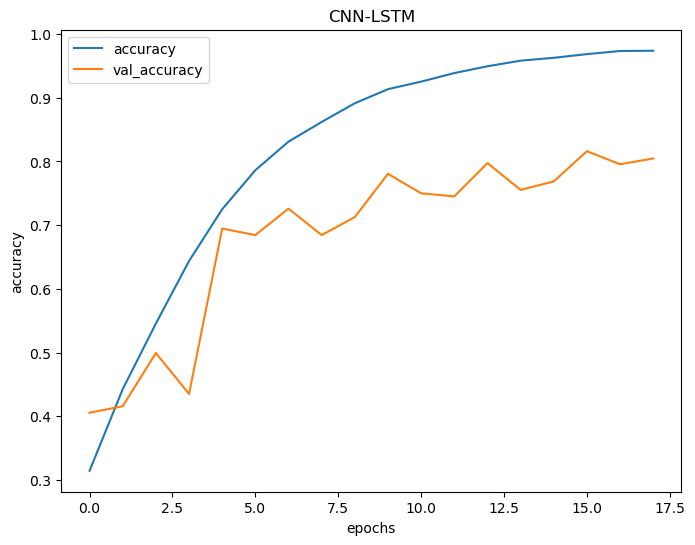

In [32]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs[:36])//2)]
y = [accs[i].cpu() for i in range(0,len(accs[:36]),2)]
z = [accs[i].cpu() for i in range(1,len(accs[:36]),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('CNN-LSTM')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [22]:
# predictions == labels

In [23]:
# model.load_state_dict(torch.load('/home/student/shokoofa/Downloads/model0.pth'))
# model.eval()

In [24]:
# print(model(test_data[183][0].unsqueeze(0).to(device)))
# # test_data[0][0].unsqueeze(0).shape
# # images.size()

# test_data[183][1]

In [25]:
# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()

#         self.conv = EfficientNet.from_pretrained('efficientnet-b0')
#         self.conv.trainable = False
#         for param in self.conv.parameters():
#             param.requires_grad = False

#     def forward(self, x):
#         seq_len, C, H, W = x.size()
#         c_in = x.view( seq_len, C, H, W)
#         c_out = self.conv.extract_features(c_in)
#         pooled = F.adaptive_avg_pool2d(c_out, (1,1))
#         pooled = pooled.view(seq_len, -1)
#         return pooled


# # x = torch.rand((1, 20, 1, 32, 32))
# xx = [torch.rand( i, 3, 224, 224) for i in range(25,30)]
# net_cnn = CNN(1)
# for x in xx:
#     features = net_cnn(x)
#     print(features.shape)

In [26]:
# class VGG(nn.Module):
#   def __init__(self, num_classes=100):
#     super().__init__()
#     self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#     )

#     self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((6, 6))
#     self.flatten = nn.Flatten(start_dim=1)
#     self.classifier = nn.Sequential(
#             nn.Linear(256*256*512, num_classes),
#             nn.ReLU(inplace=True),
#             # nn.Linear(1000, 100),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(1000, num_classes),
#             # nn.ReLU(inplace=True),
#         )

#   def forward(self, x):
#     x = self.features(x)
#     # x = self.adaptive_avg_pool2d(x)
#     x = self.flatten(x)
#     x = self.classifier(x)
#     return x

In [27]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break

In [28]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break



In [29]:
# torch.save(model.state_dict(), 'model.pt')
